In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:

class Policy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state): # Given state, computes the prob of the actions
        x = F.relu(self.linear1(state))
        x = F.relu(self.hidden(x))
        x = self.linear2(x)
        x = F.softmax(x, dim=-1)
        return x
    
    def Action(self, state): 
        '''
        Given state, samples the action according to their prob 
        and returns action and the log probability of choosing the action sampled
        '''
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.forward(state)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob

In [3]:
class Value(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        #self.hidden1  = nn.Linear(hidden_dim, hidden_dim//2)
        #self.hidden2 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        #x = F.tanh(self.hidden1(x))
        #x = F.tanh(self.hidden2(x))
        x = self.linear2(x)
        
        return x

In [4]:

def compute_return(rewards, gamma):
    G = 0
    returns = []
    
    # To compute discounted returns; Last step return and backwards
    rewards = reversed(rewards)
    for r in rewards:
        G = r + gamma*G
        returns.insert(0, G)
    
    return returns


In [5]:
gamma = 0.99
v_learning_rate = 0.015 # learning rate of value function
learning_rate = 0.001 # learning rate of the policy
hidden_dim = 256

In [6]:
def Reinforce():
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy = Policy(state_dim, hidden_dim, action_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    scores_window = deque(maxlen=100) # Moving window; keeps track of rewards of 100 episodes
    episodic_reward = [] # maintains the rewards of all episodes
    avg_reward = []
    for i in range(2000):
        
        optimizer.zero_grad()
        t_step = 0
        rewards = []
        log_probs = []
        #done = False
        
        state, _ =env.reset()
        while t_step<1000:
            t_step+=1
            action, log_prob = policy.Action(state)
            log_probs.append(log_prob)
            next_state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            
            if done:
                break
            
            state = next_state
            
        
        returns = compute_return(rewards, gamma)
        
        episodic_reward.append(sum(rewards))
        scores_window.append(sum(rewards))
        
        loss = 0
        for log_prob, G in zip(log_probs, returns):
            loss+= -log_prob*G

        loss.backward()
        optimizer.step()
        
        avg_reward.append(np.mean(scores_window))
        if i%10 == 0:
            print(f"Episode {i}\tAverage Return: {np.mean(scores_window):.2f}")
        if np.mean(scores_window)>=-100:
            print(f"\nEnvironment solved in {i} episodes! Average Return: {np.mean(scores_window):.2f}")
            break
    return episodic_reward, avg_reward

In [9]:
def Reinforce_Baseline():
    print("Reinforce BaseLine")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy = Policy(state_dim, hidden_dim, action_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    value = Value(state_dim, 256, 1).to(device)
    v_optimizer = optim.Adam(value.parameters(), lr=v_learning_rate)
    
    scores_window = deque(maxlen=100) # Moving window; keeps track of rewards of 100 episodes
    episodic_reward = [] # maintains the rewards of all episodes
    avg_reward = []
    
    for i in range(2000):
        t_step = 0
        
        states = []
        rewards = []
        log_probs = []
        #done = False
        
        state, _ =env.reset()
        while t_step<1000:
            t_step+=1
            
            action, log_prob = policy.Action(state)
            log_probs.append(log_prob)
            next_state, reward, done, _, _ = env.step(action)
            
            states.append(torch.FloatTensor(state).unsqueeze(0).to(device))
            rewards.append(reward)
            
            if done:
                break
            
            state = next_state
            
        episodic_reward.append(sum(rewards))
        scores_window.append(sum(rewards))
        
        states = torch.stack(states)
        
        returns = torch.tensor(compute_return(rewards, gamma), device=device) # G
        v_hat = value(states).squeeze(1) # value is instance of Value(class)
        
        delta = (returns - v_hat.detach())
        delta = (delta - delta.mean()) / (delta.std() + 1e-8)

        
        loss = 0
        for log_prob, G in zip(log_probs, delta):
            loss+= -log_prob*G
        loss = loss.sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
                # Updating the baseline parameters to reduce the TD error
        
        val_loss = F.mse_loss(returns, v_hat.view(-1))
        v_optimizer.zero_grad()
        val_loss.backward()
        v_optimizer.step()
        
        avg_reward.append(np.mean(scores_window))
        if i%10 == 0:
            print(f"Episode {i}\tAverage Return: {np.mean(scores_window):.2f}")
        if np.mean(scores_window)>=-100:
            print(f"\nEnvironment solved in {i} episodes! Average Return: {np.mean(scores_window):.2f}")
            break
    return episodic_reward, avg_reward

In [10]:
def pad(lists): 
    """
    Converts lists to numpy arrays; 
    Pads shorter runs so they can be stacked together.
    """
    max_len = max(len(l) for l in lists)
    padded = [np.pad(l, (0, max_len - len(l)), 'edge') for l in lists]
    return np.stack(padded)

In [11]:

env = gym.make("Acrobot-v1")

Rewards = []
Avg_Rewards = []

s = [0, 2, 5, 16, 7]
for seed in s:
    
    Seed = seed
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    env.reset(seed=Seed)

    rewards, avg_reward = Reinforce()
    Rewards.append(rewards)
    Avg_Rewards.append(avg_reward)


Episode 0	Average Return: -1000.00
Episode 10	Average Return: -724.27
Episode 20	Average Return: -678.33
Episode 30	Average Return: -656.58
Episode 40	Average Return: -657.44
Episode 50	Average Return: -606.02
Episode 60	Average Return: -582.46
Episode 70	Average Return: -581.97
Episode 80	Average Return: -549.09
Episode 90	Average Return: -515.43
Episode 100	Average Return: -483.71
Episode 110	Average Return: -435.37
Episode 120	Average Return: -395.79
Episode 130	Average Return: -357.79
Episode 140	Average Return: -312.77
Episode 150	Average Return: -292.51
Episode 160	Average Return: -267.17
Episode 170	Average Return: -231.54
Episode 180	Average Return: -226.46
Episode 190	Average Return: -223.80
Episode 200	Average Return: -228.98
Episode 210	Average Return: -234.60
Episode 220	Average Return: -244.90
Episode 230	Average Return: -251.80
Episode 240	Average Return: -249.93
Episode 250	Average Return: -250.43
Episode 260	Average Return: -251.75
Episode 270	Average Return: -251.84
Ep

In [12]:
Rewards_baseline = []
Avg_Rewards_baseline = []

s = 0
for i in range(5):
    
    Seed = s
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    env.reset(seed=Seed)

    rewards, avg_reward = Reinforce_Baseline()
    Rewards_baseline.append(rewards)
    Avg_Rewards_baseline.append(avg_reward)

Reinforce BaseLine
Episode 0	Average Return: -1000.00
Episode 10	Average Return: -287.45
Episode 20	Average Return: -233.38
Episode 30	Average Return: -207.65
Episode 40	Average Return: -193.46
Episode 50	Average Return: -184.94
Episode 60	Average Return: -181.98
Episode 70	Average Return: -174.56
Episode 80	Average Return: -173.48
Episode 90	Average Return: -168.91
Episode 100	Average Return: -160.84
Episode 110	Average Return: -155.85
Episode 120	Average Return: -151.44
Episode 130	Average Return: -148.87
Episode 140	Average Return: -144.09
Episode 150	Average Return: -142.47
Episode 160	Average Return: -137.07
Episode 170	Average Return: -136.27
Episode 180	Average Return: -140.32
Episode 190	Average Return: -139.66
Episode 200	Average Return: -132.98
Episode 210	Average Return: -128.81
Episode 220	Average Return: -128.63
Episode 230	Average Return: -129.78
Episode 240	Average Return: -131.90
Episode 250	Average Return: -131.46
Episode 260	Average Return: -133.28
Episode 270	Average

In [16]:
Rewards_np = pad(Rewards)
Avg_Rewards_np = pad(Avg_Rewards)

In [17]:
R_Basline = Rewards_baseline
Avg_R_Basline = Avg_Rewards_baseline

In [19]:
Rewards_Basline_np = pad(R_Basline)
Avg_Rewards_Baseline_np = pad(Avg_R_Basline)

In [20]:
mean_rewards_baseline = np.mean(Avg_R_Basline, axis=0)
std_rewards_baseline = np.std(Avg_R_Basline, axis=0)

mean_rewards = np.mean(Avg_Rewards_np, axis=0)
std_rewards = np.std(Avg_Rewards_np, axis=0)

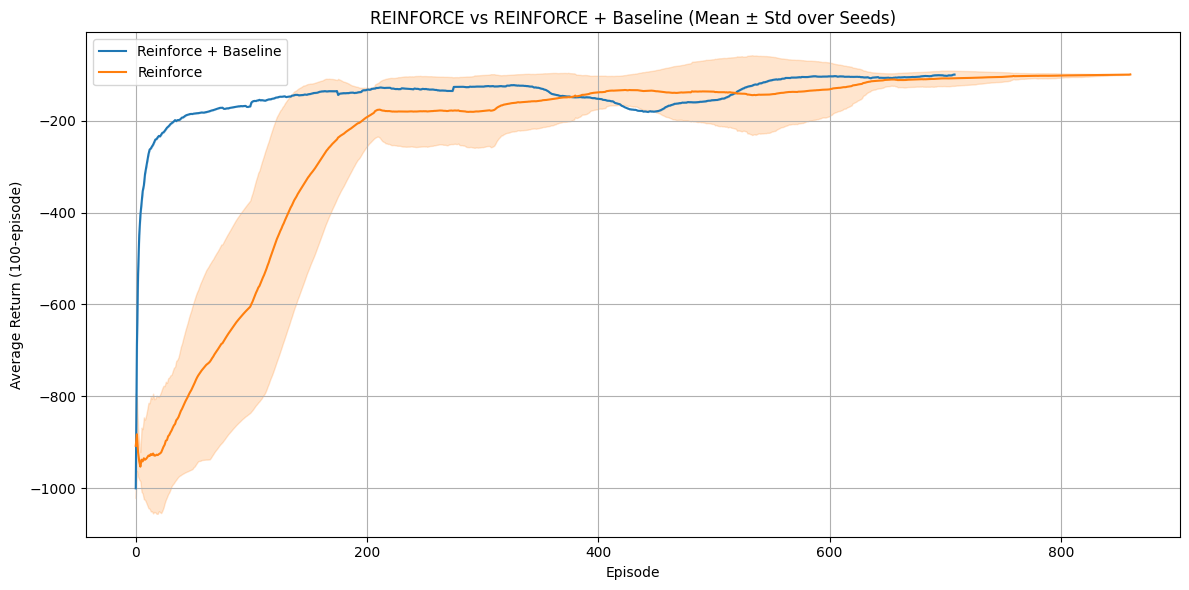

In [22]:
plt.figure(figsize=(12, 6))
x = np.arange(len(mean_rewards_baseline))

plt.plot(x, mean_rewards_baseline, label="Reinforce + Baseline", color="tab:blue")
plt.fill_between(x, mean_rewards_baseline - std_rewards_baseline, 
                mean_rewards_baseline + std_rewards_baseline, alpha=0.2, color="tab:blue")

x = np.arange(len(mean_rewards))
plt.plot(x, mean_rewards, label="Reinforce", color="tab:orange")
plt.fill_between(x, mean_rewards - std_rewards, 
                mean_rewards + std_rewards, alpha=0.2, color="tab:orange")

plt.xlabel("Episode")
plt.ylabel("Average Return (100-episode)")
plt.title("REINFORCE vs REINFORCE + Baseline (Mean ± Std over Seeds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Reinforce_Acrobotv1.png")
plt.show()
    